In [2]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `C:\Users\lukas\.julia\environments\v1.9`


In [3]:
Pkg.status()

Status `C:\Users\lukas\.julia\environments\v1.9\Project.toml`
  [87dc4568] HiGHS v1.7.5
  [7073ff75] IJulia v1.24.2
⌃ [4076af6c] JuMP v1.16.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [4]:
using JuMP, HiGHS

We want to solve a LP using Benders decomposition with dual dynamic programming – DDP
We have the problem:

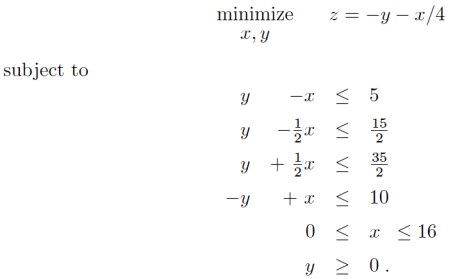

In [74]:
#initalize variables
x_input=0  #intial fixed value of x for the subproblem
wert=0 #intial value for the cancel condition
alpha=-1 #intial value for the cancel condition
i=1; #number of iteration (just for printing purposes)

In [75]:
#define and initalize dual subproblem
dual_Subproblem= Model(HiGHS.Optimizer)
set_silent(dual_Subproblem)

@variable(dual_Subproblem, λ >=0)
@variable(dual_Subproblem, γ >=0)
@variable(dual_Subproblem, μ>=0)
@variable(dual_Subproblem, β >=0)
@constraint(dual_Subproblem, -λ-γ-μ+β <= -1);


In [76]:
#define and initalize masterproblem
Masterproblem = Model(HiGHS.Optimizer)
set_silent(Masterproblem)

@variable(Masterproblem, 0 <= x <= 16)
@variable(Masterproblem, alpha_var)
@objective(Masterproblem, Min, -(x /4)+ alpha_var);

In [77]:
#solving the problem with Benders decomposition using dual dynamic programming – DDP

while wert!=alpha
    print("\n iteration no $i \n")
    
    # optimize dual subproblem with fixed value of x
    @objective(dual_Subproblem, Max, -λ*(5+x_input)+ -γ*(7.5+(x_input/2)) + -μ*(17.5-(x_input/2)) + -β* (10 - x_input))
    optimize!(dual_Subproblem)
        
    wert = objective_value(dual_Subproblem)
    print(wert)
    print(" objective value sub \n")
    
    # add benders cut (as constraint with dual variable from the subproblem)
    @constraint(Masterproblem, value(λ)*(-5-x) + value(γ)*(-7.5 -(x/2)) + value(μ) *(-17.5 +(x/2)) +value(β) *(-10 +x) <= alpha_var)
    
    # solve masterproblem with new constraint
    optimize!(Masterproblem)
    
        print(objective_value(Masterproblem))
    print("\n Objective_value Masterproblem \n")
    print(value(x))
    print(" value x\n")
    alpha=value(alpha_var)
    print(alpha)
    print(" value alpha\n")
    # compare solution of the subproblem with solution of alpha in the masterproblem
    print("alpha = $alpha & -y= $wert \n")
    # update fixed value of x
    x_input=value(x)
    i=i+1
    
    
end


 iteration no 1 
-5.0 objective value sub 
-25.0
 Objective_value Masterproblem 
16.0 value x
-21.0 value alpha
alpha = -21.0 & -y= -5.0 

 iteration no 2 
-9.5 objective value sub 
-15.416666666666668
 Objective_value Masterproblem 
8.333333333333334 value x
-13.333333333333334 value alpha
alpha = -13.333333333333334 & -y= -9.5 

 iteration no 3 
-11.666666666666668 objective value sub 
-15.0
 Objective_value Masterproblem 
10.0 value x
-12.5 value alpha
alpha = -12.5 & -y= -11.666666666666668 

 iteration no 4 
-12.5 objective value sub 
-15.0
 Objective_value Masterproblem 
10.0 value x
-12.5 value alpha
alpha = -12.5 & -y= -12.5 
